In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from graph_attribution.featurization import mol_to_graphs_tuple, MolTensorizer
from graph_attribution.datasets import save_graphtuples, load_graphstuples
from graph_attribution import experiments, training
from graph_attribution import graphs as graph_utils
from rdkit.Chem import rdMolChemicalFeatures

2023-05-24 10:19:13.615053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 10:19:19.489238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/plumed/2.8.2/lib:/home/xiangyan/workspace/apps/gromacs/2022.5-plumed/lib:/home/xiangyan/workspace/apps/fftw/3.3.10/lib:/home/xiangyan/workspace/apps/openmpi/4.1.5/lib:/home/xiangyan/workspace/apps/cuda/11.6/lib64:/home/xiangyan/workspace/softwares/amber22/lib:/home/xiangyan/workspace/apps/plumed/2.8.2/lib:/home/xiangyan/workspace/apps/gromacs/2022.5-plumed/lib:/home/xi

rdkit detected? True


In [15]:
df = pd.read_csv('XAI/Liver/Liver.csv')
df['smiles'] = df['SMILES']
df = df[df['label'] != 1]
df['label'] = df['label'].replace(2, 1)
valid_index = df.index
# csv file
df[['smiles', 'label']].to_csv('liver/liver_smiles.csv', index=False)
# x file
tensorizer = MolTensorizer()
x = mol_to_graphs_tuple([Chem.MolFromSmiles(smiles) for smiles in df.smiles], tensorizer)
save_graphtuples('liver/x_true.npz', [x])
# y file
y = df['label'].to_numpy().reshape(-1, 1)
np.savez('liver/y_true.npz', y=y)
# x_auc file
df = df.reset_index()
experiments.set_seed(42)
node_null, edge_null = tensorizer.get_null_vectors()
train_index = df[df.SPLIT == 'train'].index.to_numpy()
x_aug, y_aug = training.augment_binary_task(
    graph_utils.get_graphs_tf(x, train_index),
    y[train_index],
    node_null,
    edge_null,
    fraction=0.2)
save_graphtuples('liver/x_aug.npz', [x_aug])
np.savez_compressed('liver/y_aug.npz', **{'y_aug': y_aug})
# train test split file
np.savez("liver/liver_traintest_indices.npz", train_index=df[df.SPLIT == 'train'].index.to_numpy(), 
         test_index=df[df.SPLIT == 'test'].index.to_numpy())
# attribution file
tensorizer = MolTensorizer(read_interpretation=True)
atts = np.load('XAI/Liver/attributions.npz', allow_pickle=True)['attributions']
mols = []
for i, smiles in enumerate(df.smiles):
    index = valid_index[i]
    mol = Chem.MolFromSmiles(smiles)
    assert atts[index]['SMILES'] == smiles
    assert len(mol.GetAtoms()) == len(atts[index]['node_atts'])
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', str(atts[index]['node_atts'][j]))
    mols.append(mol)
att_full = [mol_to_graphs_tuple([mol], tensorizer) for mol in mols]
save_graphtuples('liver/true_raw_attribution_datadicts.npz', att_full)

In [ ]:
df = pd.read_csv('XAI/Liver/Liver.csv')
df['smiles'] = df['SMILES']
# csv file
df[['smiles', 'label']].to_csv('liver/liver_smiles.csv', index=False)
# x file
tensorizer = MolTensorizer()
x = mol_to_graphs_tuple([Chem.MolFromSmiles(smiles) for smiles in df.smiles], tensorizer)
save_graphtuples('liver/x_true.npz', [x])
# y file
y = np.zeros((len(df), 3))
for i, l in enumerate(df['label']):
    if l == 0:
        y[i][0] = 1
    elif l == 1:
        y[i][1] = 1
    elif l == 2:
        y[i][2] = 1
np.savez('liver/y_true.npz', y=y)
# np.savez('liver/y_true.npz', y=df['label'].to_numpy().reshape(-1, 1))
# train test split file
np.savez("liver/liver_traintest_indices.npz", train_index=df[df.SPLIT == 'train'].index.to_numpy(), 
         test_index=df[df.SPLIT == 'test'].index.to_numpy())
# attribution file
tensorizer = MolTensorizer(read_interpretation=True)
atts = np.load('XAI/Liver/attributions.npz', allow_pickle=True)['attributions']
mols = []
for i, smiles in enumerate(df.smiles):
    mol = Chem.MolFromSmiles(smiles)
    assert atts[i]['SMILES'] == smiles
    assert len(mol.GetAtoms()) == len(atts[i]['node_atts'])
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', str(atts[i]['node_atts'][j]))
    mols.append(mol)
att_full = [mol_to_graphs_tuple([mol], tensorizer) for mol in mols]
save_graphtuples('liver/true_raw_attribution_datadicts.npz', att_full)

In [3]:
df = pd.read_csv('XAI/Liver/Liver.csv')
df['smiles'] = df['SMILES']
# csv file
df[['smiles', 'label']].to_csv('liver/liver_smiles.csv', index=False)
# x file
tensorizer = MolTensorizer()
x = mol_to_graphs_tuple([Chem.MolFromSmiles(smiles) for smiles in df.smiles], tensorizer)
save_graphtuples('liver/x_true.npz', [x])
# y file
y = np.zeros((len(df), 3))
for i, l in enumerate(df['label']):
    if l == 0:
        y[i][0] = 1
    elif l == 1:
        y[i][1] = 1
    elif l == 2:
        y[i][2] = 1
np.savez('liver/y_true.npz', y=y)
# np.savez('liver/y_true.npz', y=df['label'].to_numpy().reshape(-1, 1))
# train test split file
np.savez("liver/liver_traintest_indices.npz", train_index=df[df.SPLIT == 'train'].index.to_numpy(), 
         test_index=df[df.SPLIT == 'test'].index.to_numpy())
# attribution file
tensorizer = MolTensorizer(read_interpretation=True)
atts = np.load('XAI/Liver/attributions.npz', allow_pickle=True)['attributions']
mols = []
for i, smiles in enumerate(df.smiles):
    mol = Chem.MolFromSmiles(smiles)
    assert atts[i]['SMILES'] == smiles
    assert len(mol.GetAtoms()) == len(atts[i]['node_atts'])
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', str(atts[i]['node_atts'][j]))
    mols.append(mol)
att_full = [mol_to_graphs_tuple([mol], tensorizer) for mol in mols]
save_graphtuples('liver/true_raw_attribution_datadicts.npz', att_full)

2023-04-28 13:39:37.398637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:39:37.424905: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/plumed/2.8.2/lib:/home/xiangyan/workspace/apps/gromacs/2022.5-plumed/lib:/home/xiangyan/workspace/apps/fftw/3.3.10/lib:/home/xiangyan/workspace/apps/openmpi/4.1.5/lib:/home/xiangyan/workspace/apps/cuda/11.6/lib64:/home/xiangyan/workspace/softwares/amber22/lib:/home/xiangyan/workspace/apps/plumed/2.8.2/lib:/home/xiangyan/workspace/apps/gromacs/2022.5-plumed/lib:/home/xiangyan/workspace/apps/fftw/3.3.10/lib:/home/xiangyan/workspace/apps/openmpi/4.1.5/lib:/home/xiangyan/workspace/ap

In [41]:
df = pd.read_csv('XAI/Mutagenicity/CAS_N6512.csv')
df['smiles'] = df['SMILES']
# csv file
df[['smiles', 'label']].to_csv('ames/ames_smiles.csv', index=False)
# x file
tensorizer = MolTensorizer()
x = mol_to_graphs_tuple([Chem.MolFromSmiles(smiles) for smiles in df.smiles], tensorizer)
save_graphtuples('ames/x_true.npz', [x])
# y file
y = df['label'].to_numpy().reshape(-1, 1)
np.savez('ames/y_true.npz', y=df['label'].to_numpy().reshape(-1, 1))
# x_auc file
experiments.set_seed(42)
node_null, edge_null = tensorizer.get_null_vectors()
train_index = df[df.splits == 'train'].index.to_numpy()
x_aug, y_aug = training.augment_binary_task(
    graph_utils.get_graphs_tf(x, train_index),
    y[train_index],
    node_null,
    edge_null,
    fraction=0.2)
save_graphtuples('ames/x_aug.npz', [x_aug])
np.savez_compressed('ames/y_aug.npz', **{'y_aug': y_aug})
# train test split file
np.savez("ames/ames_traintest_indices.npz", train_index=df[df.splits == 'train'].index.to_numpy(), 
         test_index=df[df.splits == 'test'].index.to_numpy())
# attribution file
tensorizer = MolTensorizer(read_interpretation=True)
atts = np.load('XAI/Mutagenicity/attributions.npz', allow_pickle=True)['attributions']
mols = []
for i, smiles in enumerate(df.smiles):
    mol = Chem.MolFromSmiles(smiles)
    assert atts[i]['SMILES'] == smiles
    assert len(mol.GetAtoms()) == len(atts[i]['node_atts'])
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', str(atts[i]['node_atts'][j]))
    mols.append(mol)
att_full = [mol_to_graphs_tuple([mol], tensorizer) for mol in mols]
save_graphtuples('ames/true_raw_attribution_datadicts.npz', att_full)

In [29]:
np.load('logic7/x_aug.npz', allow_pickle=True)['datadict_list'][0][0]

{'nodes': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

# Data Check

In [96]:
# the label in csv file is not correct.
# y_true.npz is correct
from graph_attribution.tasks import logic7_dataset
df = pd.read_csv('logic7/logic7_smiles.csv')
assert (logic7_dataset.get_true_predictions([Chem.MolFromSmiles(smiles) for smiles in df.smiles]) - \
    np.load('logic7/y_true.npz')['y']).sum() == 0
from graph_attribution.tasks import logic8_dataset
df = pd.read_csv('logic8/logic8_smiles.csv')
assert (logic8_dataset.get_true_predictions([Chem.MolFromSmiles(smiles) for smiles in df.smiles]) - \
    np.load('logic8/y_true.npz')['y']).sum() == 0
from graph_attribution.tasks import logic10_dataset
df = pd.read_csv('logic10/logic10_smiles.csv')
assert (logic10_dataset.get_true_predictions([Chem.MolFromSmiles(smiles) for smiles in df.smiles]) - \
    np.load('logic10/y_true.npz')['y']).sum() == 0
from graph_attribution.tasks import benzene_dataset
df = pd.read_csv('benzene/benzene_smiles.csv')
assert (benzene_dataset.get_true_predictions([Chem.MolFromSmiles(smiles) for smiles in df.smiles]) - \
    np.load('benzene/y_true.npz')['y']).sum() == 0

In [128]:
# the last column in true_raw_attribution_datadicts.npz's graphtuple.nodes is correct attribution ground truth.
from rdkit.Chem.rdchem import BondType
def is_atom_in_benzene_ring(atom):
    if atom.IsInRing() and atom.GetIsAromatic() and atom.GetAtomicNum() == 6:
        ring_info = atom.GetOwningMol().GetRingInfo()
        atom_rings = ring_info.AtomRings()
        atom_idx = atom.GetIdx()

        for ring in atom_rings:
            if atom_idx in ring and len(ring) == 6:
                # Check if all atoms in the ring are carbon atoms
                carbon_atoms = [atom.GetOwningMol().GetAtomWithIdx(idx).GetAtomicNum() == 6 for idx in ring]
                if all(carbon_atoms):
                    # Check if all carbon atoms in the ring are aromatic
                    aromatic_atoms = [atom.GetOwningMol().GetAtomWithIdx(idx).GetIsAromatic() for idx in ring]
                    if all(aromatic_atoms):
                        return True
    return False
def is_atom_fluoride(atom):
    return atom.GetAtomicNum() == 9
def is_atom_in_carbonyl_group(atom):
    if atom.GetAtomicNum() == 6:  # Check if the atom is carbon
        for neighbor in atom.GetNeighbors():
            bond = atom.GetOwningMol().GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            if neighbor.GetAtomicNum() == 8 and bond.GetBondType() == BondType.DOUBLE:  # Check if the neighbor is oxygen with a double bond
                return True
    return False
def is_logic(atom, dataset):
    if dataset ==  'benzene':
        return is_atom_in_benzene_ring(atom)
    elif dataset  == 'logic7':
        return is_atom_fluoride(atom) or is_atom_in_carbonyl_group(atom)
        
dataset = 'logic7'
atts = load_graphstuples(f'{dataset}/true_raw_attribution_datadicts.npz')
df = pd.read_csv(f'{dataset}/{dataset}_smiles.csv')
for i, smiles in enumerate(df.smiles):
    print(i, smiles)
    mol = Chem.MolFromSmiles(smiles)
    for j, truth in enumerate(atts[i].nodes[:,-1]):
        atom = mol.GetAtomWithIdx(j)
        if truth == 0:
            assert is_logic(atom, dataset) is False
        else:
            assert is_logic(atom, dataset) is True
            

0 CCOc1c(c(cc(n1)c1ccccc1)c1ccc(cc1)C)C#N
1 c1cc(oc1)/C=C/C=C/1\CCC/C(=C/C=C/c2ccco2)/C1=O


AssertionError: 

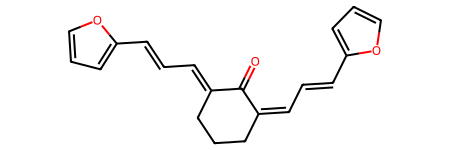

In [129]:
Chem.MolFromSmiles('c1cc(oc1)/C=C/C=C/1\CCC/C(=C/C=C/c2ccco2)/C1=O')

In [130]:
atts[1]

GraphsTuple(nodes=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32), edges=None, receivers=array([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  2,  6,  5,  7,  6,  8,  7,  9,
        8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16,
       18, 17, 19, 18, 20, 19, 21, 12, 22, 21,  0,  4,  8, 21, 16, 20],
      dtype=int32), senders=array([ 0,  1,  1,  2,  2,  3,  3,  4,  2,  5,  5,  6,  6,  7,  7,  8,  8,
        9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,
       17, 18, 18, 19, 19, 20, 12, 21, 21, 22,  4,  0, 21,  8, 20, 16],
      dtype=int32), globals=array([[0.]], dtype=float32), n_node=array([23], dtype=int32), n_edge=array([50], dtype=int32))

In [131]:
df

,mol_id,smiles,label
0,ZINC00042604,CCOc1c(c(cc(n1)c1ccccc1)c1ccc(cc1)C)C#N,0
1,ZINC00048354,c1cc(oc1)/C=C/C=C/1\CCC/C(=C/C=C/c2ccco2)/C1=O,0
2,ZINC00056300,CC1(Cc2c(c(o[nH+]2)N)C(N1O)(C)C)C,0
3,ZINC00056588,COC(=O)c1ccccc1S(=O)(=O)N,0
4,ZINC00064303,c1cc(ccc1/C=N/N1C(=O)[C@@H]2[C@H]3C=C[C@@H]([C...,0
...,...,...,...
4321,ZINC97679909,CCN(Cc1c[nH+]c([nH]1)C)[C@@H]1CCOC(C1)(C)C,0
4322,ZINC98125369,COc1cccc2c1OC/C(=C\c1ccc(cc1)[N+](=O)[O-])/C2=O,0
4323,ZINC98161391,Cc1ccc(cc1[N+](=O)[O-])[C@H](C)NCc1ccc(c(c1)F)F,0
4324,ZINC98178836,CC1([C@H]2[C@H](O2)c2ccc(cc2O1)C#N)C,0


In [113]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def is_atom_in_benzene_ring(atom):
    if atom.IsInRing() and atom.GetIsAromatic() and atom.GetAtomicNum() == 6:
        ring_info = atom.GetOwningMol().GetRingInfo()
        atom_rings = ring_info.AtomRings()
        atom_idx = atom.GetIdx()

        for ring in atom_rings:
            if atom_idx in ring and len(ring) == 6:
                # Check if all atoms in the ring are carbon atoms
                carbon_atoms = [atom.GetOwningMol().GetAtomWithIdx(idx).GetAtomicNum() == 6 for idx in ring]
                if all(carbon_atoms):
                    return True
    return False

molecule = Chem.MolFromSmiles('c1ccccc1')  # Benzene

for atom in molecule.GetAtoms():
    atom_idx = atom.GetIdx()
    is_in_benzene = is_atom_in_benzene_ring(atom)
    print(f'Atom index: {atom_idx}, Is in benzene ring: {is_in_benzene}')



Atom index: 0, Is in benzene ring: True
Atom index: 1, Is in benzene ring: True
Atom index: 2, Is in benzene ring: True
Atom index: 3, Is in benzene ring: True
Atom index: 4, Is in benzene ring: True
Atom index: 5, Is in benzene ring: True


In [47]:
import pandas as pd
import numpy as np
from mgktools.features_mol import FeaturesGenerator
fg = FeaturesGenerator('morgan')
df = pd.read_csv('XAI/Liver/Liver.csv')

In [48]:
df = df[df['label'] != 1]
df_train = df[df.SPLIT=='train']
df_test = df[df.SPLIT == 'test']
X_train = np.concatenate(df_train.SMILES.apply(lambda x: fg(x).reshape(1, -1)).to_list(), axis=0)
y_train = df_train['label']
X_test = np.concatenate(df_test.SMILES.apply(lambda x: fg(x).reshape(1, -1)).to_list(), axis=0)
y_test = df_test['label']

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.7815668202764977